# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Nguyễn Trần Thiên An
- MSSV: 23127315
- Lớp: 23CLC04

## Import các thư viện liên quan

In [55]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Helper functions

In [56]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''

    # YOUR CODE HERE
    img = Image.open(img_path).convert('RGB')
    return np.array(img).astype(np.uint8)


def show_img(img_2d):
    '''
    Show image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    '''

    # YOUR CODE HERE
    plt.figure(figsize=(7,7))
    plt.imshow(img_2d)
    plt.axis('off')
    plt.show()


def save_img(img_2d, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    '''

    # YOUR CODE HERE
    Image.fromarray(img_2d).save(img_path)


def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    '''

    # YOUR CODE HERE
    m, n, num_channels = img_2d.shape
    return img_2d.reshape((-1, num_channels))


def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    
    # YOUR CODE HERE
    # initialize
    centroids = initialize_centroids(img_1d, k_clusters, init_centroids)

    # type casting for calculate more accurately and faster
    img_1d = img_1d.astype(np.float32)
    centroids = centroids.astype(np.float32)

    # Calculate the squared norms of all pixels in the image
    img_squared_norm = np.sum(img_1d**2, axis=1, keepdims=True)  # shape: (height * width, 1)

    for interation in range(max_iter):
        labels = get_labels(img_1d, centroids, img_squared_norm)
        new_centroids = update_centroids(img_1d, k_clusters, labels, centroids)
        if is_converged(centroids, new_centroids):
            break
        centroids = new_centroids
    
    return centroids, labels


def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : np.ndarray with shape=(height * width, num_channels)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''

    # YOUR CODE HERE
    img_1d = centroids[labels]
    img_2d = img_1d.reshape(img_2d_shape)
    return img_2d.astype(np.uint8)



# Your additional functions here

def initialize_centroids(img_1d, k_clusters, init_centroids):
    '''
    Initialize centroids with number of k_cluster.

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image (the same as img_1d).
    k_clusters : int
        Number of clusters
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster
    Returns
    -------
        A 2D array where each element corresponds to a pixel and contains an array of distances to all centroids.
            For example: [[1, 2, 3], [10, 20, 30]] => pixel 0 has distance to 'centroid 0: 1'; 'centroid 1: 2',...
    '''

    if init_centroids == 'random':
        centroids = np.random.randint(0, 256, size = (k_clusters, img_1d.shape[1]), dtype=np.uint8)
    elif init_centroids == 'in_pixels':
        # pick random indices from 0 to img_1d.shape[0] - 1 without duplication
        sample_indices = np.random.choice(img_1d.shape[0], size=k_clusters, replace=False)

        # fancy indexing
        centroids = img_1d[sample_indices]
    return centroids


def calculate_distances(img_1d, centroids, img_squared_norm):
    '''
    Calculate the distances from all pixels to all centroids by the formula
        sqrt(||pixels - centroids||^2) = sqrt(||pixels||^2 - 2 * pixels * centroids + ||centroids||^2)

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image (the same as img_1d).
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids.
    img_squared_norm : np.ndarray with shape=(height * width, 1)
        An array of each pixel's norm square.

    Returns
    -------
        A 2D array where each element corresponds to a pixel and contains an array of distances to all centroids.
            For example: [[1, 2, 3], [10, 20, 30]] => pixel 0 has distance to 'centroid 0: 1'; 'centroid 1: 2',...
    '''
    centroids_squared_norms = np.sum(centroids ** 2, axis=1)
    dot_product = np.dot(img_1d, centroids.T)

    squared_distances = img_squared_norm - 2 * dot_product + centroids_squared_norms

    return np.sqrt(squared_distances)

def get_labels(img_1d, centroids, img_squared_norm):
    '''
    Assign each pixel to the nearest centroid.

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image (the same as img_1d).
    
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids.
    
    img_squared_norm : np.ndarray with shape=(height * width, 1)
        Precomputed squared norms (||x||^2) of each pixel vector for distance calculation.

    Returns
    -------
    np.ndarray with shape=(height * width,)
        Array of labels where each element is the index of the closest centroid for that pixel.
    '''
    distances = calculate_distances(img_1d, centroids, img_squared_norm)
    return np.argmin(distances, axis = 1)


def update_centroids(img_1d, k_clusters, labels, old_centroids):
    '''
    Update each centroid to the mean of pixels assigned to its cluster.

    Parameters
    ----------
    img_1d : np.ndarray with shape=(num_pixels, num_channels)
        Original (1D) image (the same as img_1d).

    k_clusters : int
        Total number of clusters.

    labels : np.ndarray with shape=(num_pixels,)
        Array assigning each pixel to a cluster.

    old_centroids : np.ndarray with shape=(k_clusters, num_channels)
        Previous centroids.

    Returns
    -------
    np.ndarray with shape=(k_clusters, num_channels)
        Updated centroid array. If a cluster is empty, its previous centroid is retained.
    '''
    centroids = np.zeros_like(old_centroids)
    for k in range(k_clusters):
        kth_cluster_pixels = img_1d[labels == k]
        if kth_cluster_pixels.size > 0:
            centroids[k] = kth_cluster_pixels.mean(axis = 0)
        else:
            random_idx = np.random.choice(img_1d.shape[1])
            centroids[k] = img_1d[random_idx]
    return centroids


def is_converged(centroids, new_centroids):
    '''
    Check if K-means centroids have converged.

    Parameters
    ----------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color of previous centroids.
    new_centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color of calculated centroids.
    

    Returns
    -------
        True if the maximum absolute difference between centroids and new_centroids is below the threshold (1e-6), 
        else False.
    '''
    return np.max(np.abs(new_centroids - centroids)) < 1e-6


## Your tests

In [57]:
# YOUR CODE HERE

## Main FUNCTION

In [58]:
def main():
    img_path = input("Enter the path of image for input: ")
    k_clusters = int(input("Enter the number of cluster (k): "))
    output_format = input("Enter output format (pdf/png): ").strip().lower()

    while output_format not in ['pdf', 'png']:
        print("Invalid format. Please enter either 'pdf' or 'png'.")
        output_format = input("Enter output format (pdf/png): ").strip().lower()

    output_path = f"compressed_image.{output_format}"

    max_iter = 10000
    init_centroids='random'

    img_2d = read_img(img_path)

    print(f"The original image of the path '{img_path}' you gave: ")
    show_img(img_2d)

    img_1d = convert_img_to_1d(img_2d)
    centroids, labels = kmeans(img_1d, k_clusters, max_iter, init_centroids)
    img_quantized = generate_2d_img(img_2d.shape, centroids, labels)

    print(f"The compressed image with k = {k_clusters} and init_centroids = {init_centroids}: ")
    show_img(img_quantized)
    save_img(img_quantized, output_path)

The original image of the path 'i9.jpg' you gave: 


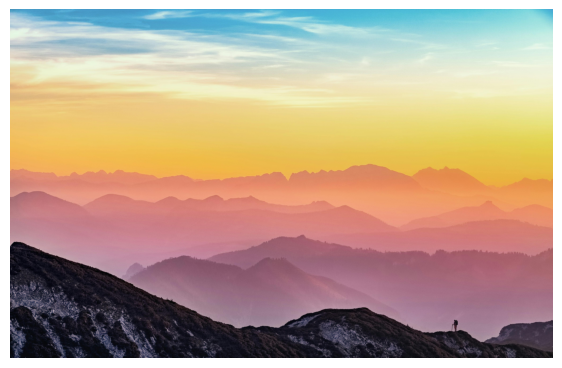

The compressed image with k = 7 and init_centroids = random: 


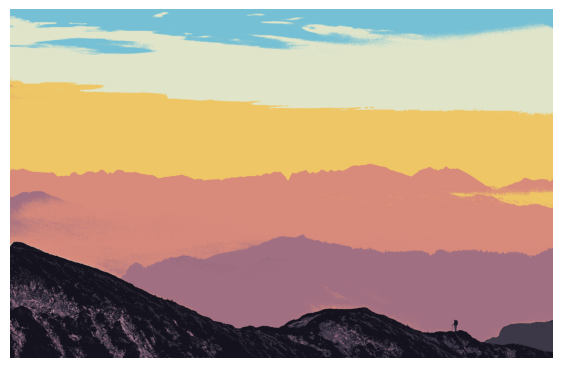

In [61]:
main()